In [1]:
import sys
from pathlib import Path

path_root = Path( '/project_ghent/HADSP/reservoirpy/')
sys.path.append(str(path_root))
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

In [3]:
from importlib import reload

# Utility functions
from reservoir.utility import show_matrice

# SEED
SEED = 3789

# Reservoir functions

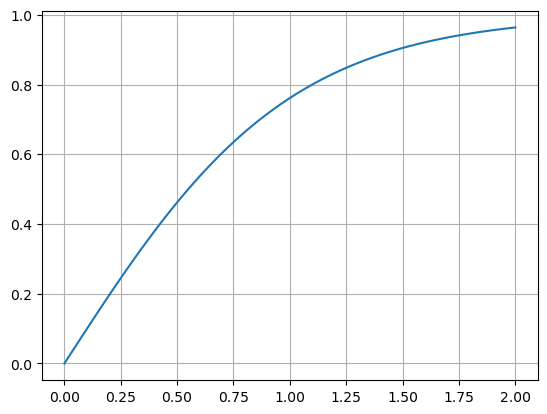

In [4]:
from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Mackey-Glass

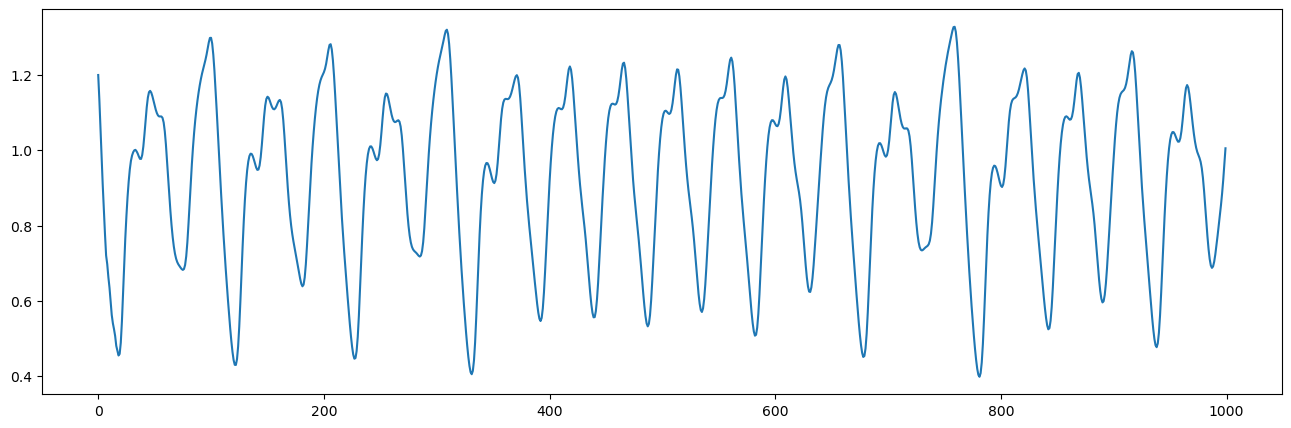

In [5]:
from reservoirpy.datasets import mackey_glass

timesteps = 10000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

# Define the time step of your Mackey-Glass system
dt = 0.00001

# Compute the equivalent sampling rate
sampling_rate = 1 / dt

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), mg_inputs[:1000])
plt.show()

## Japanese voyels

In [6]:
from reservoirpy.datasets import japanese_vowels

X_train, Y_train, X_test, Y_test = japanese_vowels()

In [7]:
X_pretrain = np.concatenate(X_train, axis=0)
X_pretrain.shape
filtered_data = X_pretrain.T

## InsectWingbeat

## MELD

https://github.com/declare-lab/MELD


## Free Spoken Digits Dataset

In [8]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import os

data_dir = 'datasets/fsdd/free-spoken-digit-dataset-master/recordings'  # Path to the extracted dataset

# Get the list of all audio files in the dataset directory
audio_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.wav')]

# Create a TensorFlow dataset from the audio files
audio_files_dataset = tf.data.Dataset.from_tensor_slices(audio_files)

# Print the number of audio files in the dataset
print("Number of audio files:", len(audio_files))

def process_audio(file_path):
    filename = tf.strings.split(file_path, '/')[-1]
    
    # Extract the label from the filename
    label = tf.strings.split(filename, '_')[0]
    speaker = tf.strings.split(filename, '_')[1]
    audio = tf.io.read_file(file_path)
    audio, sampling_rate = tf.audio.decode_wav(audio, desired_channels=1)
    
    return {
        'label': label,
        'audio': audio,
        'audio/filename': filename,
        'speaker': speaker,
    }, sampling_rate

audio_files_dataset = audio_files_dataset.map(process_audio, num_parallel_calls=tf.data.AUTOTUNE)

feature_dict = []
sampling_rates = []

for data, sampling_rate in tqdm(audio_files_dataset):
    feature_dict.append(data)
    sampling_rates.append(sampling_rate.numpy())

# Calculate and print the mean sampling rate
sampling_rate = np.mean(np.array(sampling_rates))
print("Mean sampling rate:", sampling_rate) # Should be 8000


2023-07-24 08:18:37.657147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 08:18:38.958823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of audio files: 3000


  0%|          | 0/3000 [00:00<?, ?it/s]2023-07-24 08:18:40.868130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3000]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 3000/3000 [00:01<00:00, 2892.83it/s]

Mean sampling rate: 8000.0


In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# List to store the features and labels
features = []
labels = []

# Iterate over the feature dictionary and store the features and labels
for item in feature_dict:
    features.append(item['audio'].numpy())  # Use numpy() to convert the tensor to a numpy array
    labels.append(item['label'].numpy())  # Use numpy() to convert the tensor to a numpy array

# Convert the features and labels to numpy arrays
X = np.array(features)
Y = np.array(labels)

# Encode the labels
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

# One-hot encode the labels
ohe = OneHotEncoder(sparse_output=False)
Y_one_hot = ohe.fit_transform(Y_encoded.reshape(-1, 1))

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.5, random_state=42)  # Use 20% of the data for the test set

# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1500,)
Y_train shape: (1500, 10)
X_test shape: (1500,)
Y_test shape: (1500, 10)


/tmp/ipykernel_1800/2280759028.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(features)


In [10]:
#take a long time (15min with half the samples, instant with 20 which is enought for pretraining)
X_pretrain = np.concatenate(X_train[:20], axis=0)

# New inputs creation with band filters

Spectrograms_vs_Cochleagrams : 
* https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

## Which dataset to choose ?

## Spectral density and peak selection

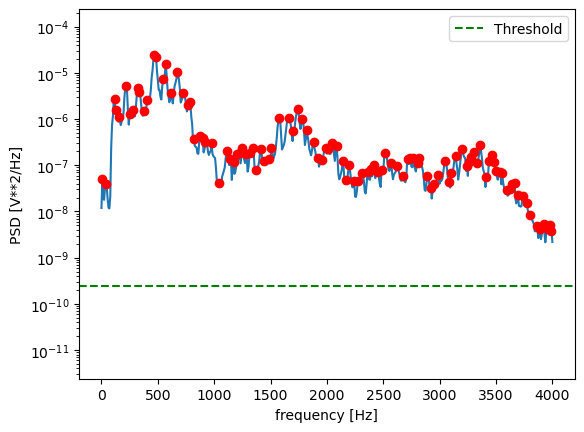

Filtered peak frequencies:  [   7.8125   39.0625  117.1875  132.8125  156.25    218.75    250.
  281.25    320.3125  335.9375  375.      406.25    468.75    484.375
  546.875   570.3125  617.1875  671.875   726.5625  765.625   781.25
  820.3125  875.      898.4375  921.875   976.5625 1046.875  1117.1875
 1140.625  1171.875  1203.125  1226.5625 1250.     1281.25   1320.3125
 1343.75   1367.1875 1414.0625 1445.3125 1484.375  1507.8125 1578.125
 1664.0625 1703.125  1742.1875 1781.25   1820.3125 1882.8125 1921.875
 1953.125  1992.1875 2007.8125 2046.875  2085.9375 2140.625  2171.875
 2195.3125 2242.1875 2273.4375 2312.5    2367.1875 2390.625  2414.0625
 2437.5    2453.125  2484.375  2515.625  2570.3125 2625.     2671.875
 2718.75   2734.375  2765.625  2804.6875 2820.3125 2890.625  2921.875
 2953.125  2984.375  3046.875  3085.9375 3101.5625 3140.625  3195.3125
 3242.1875 3257.8125 3281.25   3304.6875 3328.125  3359.375  3414.0625
 3437.5    3460.9375 3484.375  3500.     3531.25   3554.6875 

In [11]:
from dataset_generation.multivariate_generation import generate_multivariate_dataset

filtered_peak_freqs = generate_multivariate_dataset(X_pretrain.flatten(), sampling_rate, nperseg=1024)

## Applying normal band pass filter on data

### Pretrain data

In [12]:
from scipy.signal import butter, lfilter
from scipy.fft import fft

def butterworth_filter(data, lowcut, highcut, fs, btype='band', order=2):
    b, a = butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype=btype)
    return lfilter(b, a, data).flatten()

lowcut = np.concatenate(([filtered_peak_freqs[0]], (filtered_peak_freqs[:-1] + filtered_peak_freqs[1:]) / 2))
highcut = np.concatenate(((filtered_peak_freqs[:-1] + filtered_peak_freqs[1:]) / 2, [filtered_peak_freqs[-1]]))

# Pretrain data
modulated_time_series = list(map(lambda f: butterworth_filter(X_pretrain.flatten(), lowcut[f], highcut[f], fs=sampling_rate), range(len(filtered_peak_freqs))))
modulated_time_series = np.array(modulated_time_series)
modulated_time_series.shape

(111, 68992)

### Train data

In [13]:
from tqdm import tqdm
from joblib import Parallel, delayed

def process_sample(x):
    return list(map(lambda f: butterworth_filter(x, lowcut[f], highcut[f], fs=sampling_rate), range(len(filtered_peak_freqs))))

# Use all available cores
n_jobs = -1

X_train_band = np.array(
    Parallel(n_jobs=n_jobs, verbose=1)(delayed(process_sample)(x) for x in X_train)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   17.1s finished
/tmp/ipykernel_1800/3905288632.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_band = np.array(


### Test data

In [14]:
# Test
X_test_band = np.array(
    Parallel(n_jobs=n_jobs, verbose=1)(delayed(process_sample)(x) for x in X_test)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.5s finished
/tmp/ipykernel_1800/267793072.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_band = np.array(


### Standardize the amplitudes

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
filtered_data = scaler.fit_transform(modulated_time_series)
# train
X_train_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_train_band]
# test
X_test_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_test_band]

In [16]:
X_train_band[0].shape

(111, 2882)

# Generating reservoirs

## Creating from HADSP + bandfilter

### Plot  pretrain dataset

In [17]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/filtered_peak_freqs[-1]

min_window_size

2.003913894324853

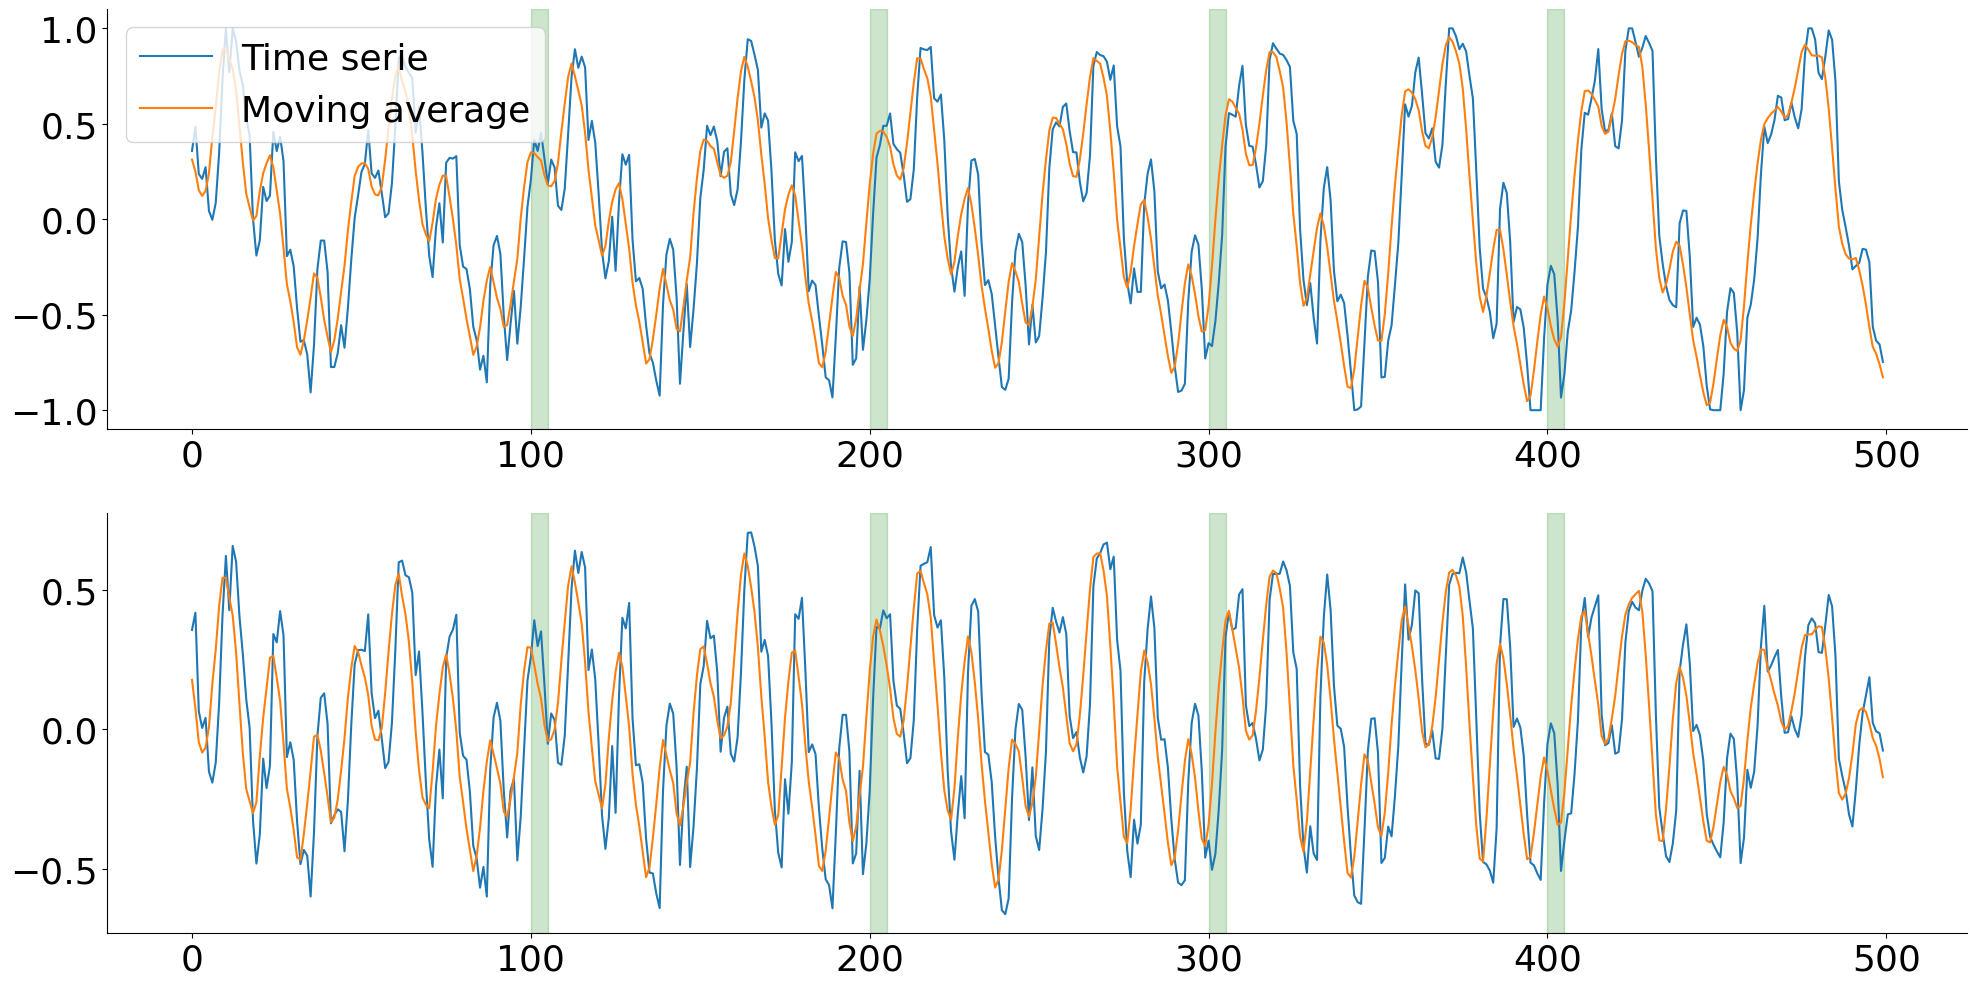

In [18]:
#Compute the moving average 
window_size = 5
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

#CPlot the two for different frequencies
NB_1 = 3
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(500), filtered_data[NB_1, 1000:1500], label='Time serie')
ax[0].plot(range(500), ma[NB_1, 1000:1500], label='Moving average')
NB_2 = 10
ax[0].legend(fontsize=26)
ax[1].plot(range(500), filtered_data[NB_2, 1000:1500], label='Time serie')
ax[1].plot(range(500), ma[NB_2, 1000:1500], label='Moving average')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', labelsize=26)
ax[1].tick_params(axis='both', labelsize=26)


# draw vertical lines to represent the window for some points
for x in range(100, 500, 100):
    ax[0].axvspan(x, x+window_size, color='g', alpha=0.2)
for x in range(100, 500, 100):
    ax[1].axvspan(x, x+window_size, color='g', alpha=0.2)

plt.show()

### construct matrice

In [19]:
import math 

# We want the size of the reservoir to be at least 200
k = math.ceil(200 / filtered_data.shape[0])
frequency_bands = np.repeat(filtered_data, k, axis=0)

n = frequency_bands.shape[0]

frequency_bands.shape

(222, 68992)

In [20]:
import reservoir.reservoir
from reservoir.reservoir import update_reservoir
from reservoir.reservoir import init_matrices

INCREMENT = 5
VALUE = 0.05
target_rate = 0.7
growth_parameter = 0.3

bias_scaling = 1
input_scaling = 0.5
leaky_rate = 1

# Initialisation EE
Win_hasp_band, W_hasp_band, bias_hasp_band =  init_matrices(n, 1, 0, seed=SEED)
bias_hasp_band = bias_hasp_band*bias_scaling
Win_hasp_band = Win_hasp_band*input_scaling


# last_state
state_e = np.random.uniform(0, 1, n)
step=0

state_history_e = []

total_add = 0
total_prun = 0
add = []
prun = []

In [21]:
from connexion_generation.utility import compute_synaptic_change
from connexion_generation.bounded_adsp import bounded_adsp

for i in range(INCREMENT*5):
    state_e = update_reservoir(W_hasp_band, Win_hasp_band, frequency_bands[:, i], state_e, leaky_rate, bias_hasp_band, activation_function)
    state_history_e.append(state_e)
frequency_bands = frequency_bands[:, INCREMENT * 5:]
train_length = len(frequency_bands[1,:])

# size of simulation 
number_steps = frequency_bands.shape[1]
for k in tqdm(range(int(number_steps/INCREMENT))): 
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="WHOLE")
    W_hasp_band, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_hasp_band, state_e, delta_z_e, VALUE)

    for i in range(INCREMENT):
        state_e = update_reservoir(W_hasp_band, Win_hasp_band, frequency_bands[:, i], state_e, leaky_rate, bias_hasp_band, activation_function)
        state_history_e.append(state_e)
    frequency_bands = frequency_bands[:, INCREMENT:]
    
    total_add += nb_new_add_e
    total_prun += nb_new_prun_e
    add.append(total_add)
    prun.append(total_prun)

    step += 1
add = np.array(add)
prun = np.array(prun)

100%|██████████| 13793/13793 [00:17<00:00, 781.78it/s] 


<Axes: >

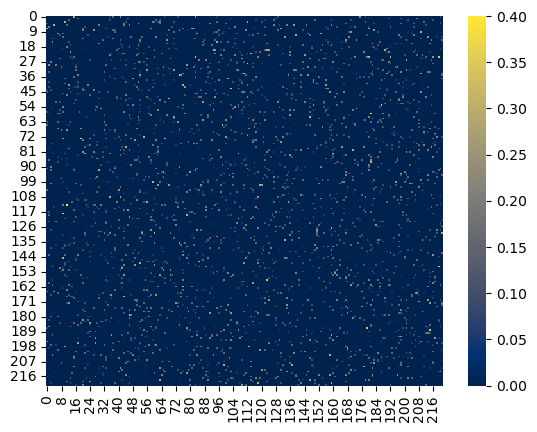

In [22]:
heatmap(W_hasp_band.todense(), cmap=color_palette("cividis", as_cmap=True))

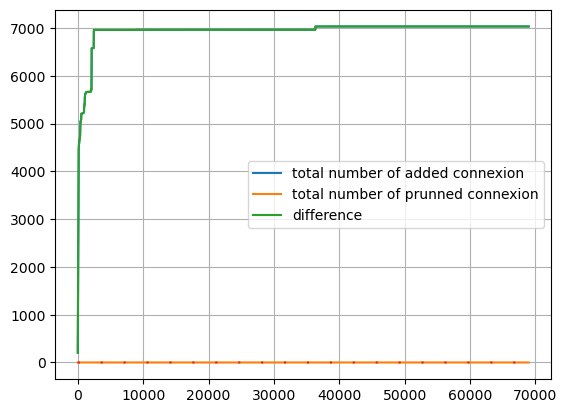

In [23]:
plt.figure()
plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
plt.legend()
plt.grid()

We create the matrice with same data and same size but randomly generated

In [24]:
# 3rd (normal + band)
connectivity_band =  W_hasp_band.count_nonzero() / (W_hasp_band.shape[0] * W_hasp_band.shape[1])
# (adsp + band)
eigen_adsp = sparse.linalg.eigs(W_hasp_band, k=1, which="LM", maxiter=W_hasp_band.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))

Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_band, sr_adsp)
bias_3= bias_3*bias_scaling
Win_3= Win_3*0.3
eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))


## Creating matrice from HADSP+Mackey Glass

In [25]:
from reservoir.reservoir import update_reservoir
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_adsp import bounded_adsp
from connexion_generation.utility import compute_synaptic_change

# Initialisation EE
Win_hadsp_uni, W_hadsp_uni, bias_hadsp_uni = init_matrices(n, 1, 0, seed=SEED)
bias_hadsp_uni = bias_hadsp_uni*bias_scaling
Win_hadsp_uni = Win_hadsp_uni*input_scaling

# initial state
state_hadsp_uni = np.random.uniform(0, 1, n)

target_rate = 0.8 #  0.9 show good results as well
growth_parameter = 0.1

step=0
state_history_hadsp_uni = []
total_added = 0
total_pruned = 0
add = []
prun = []

input_data = X_pretrain.flatten()
input_data.shape

(68992,)

In [26]:
for i in range(INCREMENT*5):
    state_hadsp_uni = update_reservoir(W_hadsp_uni, Win_hadsp_uni, input_data[i], state_hadsp_uni, leaky_rate, bias_hadsp_uni, activation_function)
    state_history_hadsp_uni.append(state_hadsp_uni)
input_data = input_data[INCREMENT * 5:]

number_steps = input_data.shape[0]
for k in tqdm(range(int(number_steps/INCREMENT))): 
    delta_z = compute_synaptic_change(state_history_hadsp_uni[-INCREMENT:], target_rate, growth_parameter, average="WHOLE")
    W_hadsp_uni, _, nb_new_add, nb_new_prun = bounded_adsp(W_hadsp_uni, state_hadsp_uni, delta_z, VALUE)

    for i in range(INCREMENT):
        state_hadsp_uni = update_reservoir(W_hadsp_uni, Win_hadsp_uni, input_data[i], state_hadsp_uni, leaky_rate, bias_hadsp_uni, activation_function)
        state_history_hadsp_uni.append(state_hadsp_uni)
    input_data = input_data[INCREMENT:]

    train_length = len(mg_inputs[:])
    
    total_added += nb_new_add
    total_pruned += nb_new_prun
    add.append(total_added)
    prun.append(total_pruned)

    step += 1
add = np.array(add)
prun = np.array(prun)

100%|██████████| 13793/13793 [00:29<00:00, 469.84it/s] 


<Axes: >

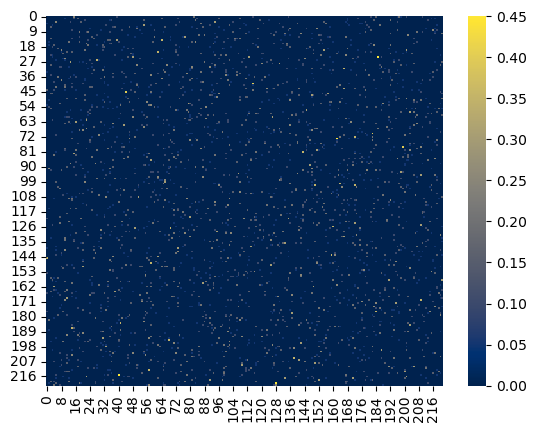

In [27]:
heatmap(W_hadsp_uni.todense(), cmap=color_palette("cividis", as_cmap=True))

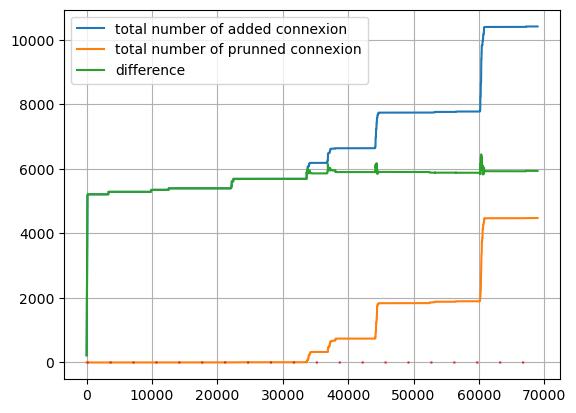

In [28]:
plt.figure()
plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
plt.legend()
plt.grid()

We create Matrices without HADSP (normal)

In [29]:
from scipy import stats

# (normal + random)
# network 2 = HADSP generated on random data
# We generate a network randomly same connectivity as the HADSP generated one
connectivity_hadsp_uni =  W_hadsp_uni.count_nonzero() / (W_hadsp_uni.shape[0] * W_hadsp_uni.shape[1])
Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_hadsp_uni)
bias_normal= bias_normal*bias_scaling
Win_normal= Win_normal*0.3

# Set the input matrices for the two HADSPs
#Win_hasp_band = Win_normal
#Win_hadsp_multi = Win_normal

## Spectral radius normalisation

In [30]:
# (normal + random)
eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))

# 2th  (HADSP + random)
eigen_hadsp_uni = sparse.linalg.eigs(W_hadsp_uni, k=1, which="LM", maxiter=W_hadsp_uni.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_hadsp_uni = max(abs(eigen_hadsp_uni))

In [31]:
print(sr_normal)
print(sr_hadsp_uni)
print(sr_3)
print(sr_adsp)

1.0000000000833116
1.3544375873245547
1.5779137951316589
1.5779137956033829


In [60]:
# Spectral radius normalisation
normal_sr = 0.9
W_normal = W_normal/sr_normal*normal_sr
W_hadsp_uni = W_hadsp_uni/sr_hadsp_uni*normal_sr
W_3 = W_3/sr_3*normal_sr
W_hasp_band = W_hasp_band/sr_adsp*normal_sr

# Performance

## Classification

### Training

In [61]:
X_train[0].shape

(2882, 1)

In [62]:
# Create a list to store the arrays

# We want the size of the reservoir to be at least 200
k = math.ceil(200 / filtered_data.shape[0])
caca = []
caca_test = []
for i in tqdm(range(len(X_train_band))):
    #caca.append(np.repeat(X_train[i], k, axis=1))
    caca.append(np.repeat(X_train_band[i], k, axis=0).T) # axis still depend of X_train shape
for i in tqdm(range(len(X_test_band))):
    #caca_test.append(np.repeat(X_test[i], k, axis=1))
    caca_test.append(np.repeat(X_test_band[i], k, axis=0).T)
    
caca[0].shape

100%|██████████| 1500/1500 [00:12<00:00, 123.61it/s]


(2882, 222)

In [63]:
print(k)
print(len(caca))
print(caca[0].shape)

2
1500
(2882, 222)


In [64]:
import reservoirpy.nodes
from reservoirpy.nodes import Reservoir, Ridge, Input, ESN
reload(reservoirpy.nodes)
from scipy.sparse import csr_matrix
ridge_coef = 1e-6

source = Input()
# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias

In [66]:
N_JOBS = 1

In [67]:
# Training HADSP + mutlivariate dataset
reservoir_hasp_band = Reservoir(units=n, 
                                W =csr_matrix(W_hasp_band), 
                                Win=csr_matrix(np.diag(Win_hasp_band.toarray().flatten())), 
                                bias=csr_matrix(bias_hasp_band).T, 
                                activation=activation_function,
                                equation='external'
                               )
readout_hasp_band = Ridge(ridge=ridge_coef)
model_hasp_band = ESN(reservoir=reservoir_hasp_band, readout=readout_hasp_band, workers=4)

states_train_hasp_band = []
def compute_state(x):
    return reservoir_hasp_band.run(x, reset=True)[-1, np.newaxis].flatten()

states_train_hasp_band = Parallel(n_jobs=N_JOBS)(delayed(compute_state)(x) for x in caca)

Running Reservoir-5: 100%|██████████| 4205/4205 [00:00<00:00, 9883.43it/s]


In [68]:
# Training random + mutlivariate dataset
reservoir_3 = Reservoir(units=n, 
                        W =csr_matrix(W_3), 
                        Win=csr_matrix(np.diag(Win_3.toarray().flatten())), 
                        bias=csr_matrix(bias_3).T, 
                        activation=activation_function,
                        equation='external'
                       )
readout_3 = Ridge(ridge=ridge_coef)
model_3 = ESN(reservoir=reservoir_3, readout=readout_3, workers=-1)

states_train_3 = []

def compute_state(x):
    return reservoir_3.run(x, reset=True)[-1, np.newaxis].flatten()

states_train_3 = Parallel(n_jobs=N_JOBS)(delayed(compute_state)(x) for x in caca)


Running Reservoir-6: 100%|██████████| 4205/4205 [00:00<00:00, 9817.00it/s]


### Performance

In [69]:
print(len(states_train_3))
states_train_3[0].shape

1500


(222,)

In [70]:
print(len(Y_train))
np.array(Y_train).shape

1500


(1500, 10)

In [71]:
#readout_hasp_band.fit(states_train_hasp_band, Y_train)
readout_hasp_band.fit(np.array(states_train_hasp_band), Y_train)

Y_pred_hasp_band = []
def predict(x):
    states = reservoir_hasp_band.run(x, reset=True)
    y = readout_hasp_band.run(states[-1, np.newaxis])
    return y

Y_pred_hasp_band = Parallel(n_jobs=N_JOBS)(delayed(predict)(x) for x in caca_test)

Running Ridge-5: 100%|██████████| 1/1 [00:00<00:00, 9320.68it/s]


In [72]:
#readout_3.fit(states_train_3, Y_train)
readout_3.fit(np.array(states_train_3), Y_train)


Y_pred_3 = []
def predict(x):
    states = reservoir_3.run(x, reset=True)
    y = readout_3.run(states[-1, np.newaxis])
    return y

Y_pred_3 = Parallel(n_jobs=N_JOBS)(delayed(predict)(x) for x in caca_test)

Running Ridge-6: 100%|██████████| 1/1 [00:00<00:00, 8019.70it/s]


In [73]:
from sklearn.metrics import accuracy_score

Y_pred_class = [np.argmax(y_p) for y_p in Y_pred_hasp_band]
Y_test_class = [np.argmax(y_t) for y_t in Y_test]

score = accuracy_score(Y_test_class, Y_pred_class)

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  16.600 %


In [74]:
from sklearn.metrics import accuracy_score

Y_pred_class = [np.argmax(y_p) for y_p in Y_pred_3]
Y_test_class = [np.argmax(y_t) for y_t in Y_test]

score = accuracy_score(Y_test_class, Y_pred_class)

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  16.733 %


## Classification for univariate

### Training

In [75]:
X_train[0].shape

(2882, 1)

In [76]:
# Create a list to store the arrays

# We want the size of the reservoir to be n
k = math.ceil(n / X_train[0].shape[1])
pipi = []
pipi_test = []
for i in tqdm(range(len(X_train))):
    pipi.append(np.repeat(X_train[i], k, axis=1))
    #pipi.append(np.repeat(X_train[i], k, axis=0).T) # axis still depend of X_train shape
for i in tqdm(range(len(X_test))):
    pipi_test.append(np.repeat(X_test[i], k, axis=1))
    #pipi_test.append(np.repeat(X_test[i], k, axis=0).T)
    
pipi[0].shape

100%|██████████| 1500/1500 [00:05<00:00, 256.75it/s]


(2882, 222)

In [77]:
pipi_test[0].shape

(3399, 222)

In [78]:
# Training HADSP + univariate dataset
reservoir_hadsp_uni = Reservoir(units=n, 
                                W =csr_matrix(W_hadsp_uni), 
                                Win=csr_matrix(np.diag(Win_hadsp_uni.toarray().flatten())), 
                                bias=csr_matrix(bias_hadsp_uni).T, 
                                activation=activation_function,
                                equation='external'
                               )
readout_hadsp_uni = Ridge(ridge=ridge_coef)
model_hadsp_uni = ESN(reservoir=reservoir_hadsp_uni, readout=readout_hadsp_uni, workers=4)


states_train_hadsp_uni = []

def compute_state(x):
    return reservoir_hadsp_uni.run(x, reset=True)[-1, np.newaxis].flatten()

states_train_hadsp_uni = Parallel(n_jobs=N_JOBS)(delayed(compute_state)(x) for x in pipi)

Running Reservoir-7: 100%|██████████| 4205/4205 [00:00<00:00, 9638.74it/s]


In [ ]:
# Training HADSP + univariate dataset
reservoir_normal = Reservoir(units=n, 
                                W =csr_matrix(W_normal), 
                                Win=csr_matrix(np.diag(Win_normal.toarray().flatten())), 
                                bias=csr_matrix(bias_normal).T, 
                                activation=activation_function,
                                equation='external'
                               )
readout_normal = Ridge(ridge=ridge_coef)
model_normal = ESN(reservoir=reservoir_normal, readout=readout_normal, workers=4)


states_train_normal = []

def compute_state(x):
    return reservoir_normal.run(x, reset=True)[-1, np.newaxis].flatten()

states_train_normal = Parallel(n_jobs=N_JOBS)(delayed(compute_state)(x) for x in pipi)

Running Reservoir-8:  25%|██▌       | 970/3839 [00:00<00:00, 9697.77it/s]

### Performances

In [ ]:
#readout_hasp_uni.fit(states_train_hasp_uni, Y_train)
readout_hadsp_uni.fit(np.array(states_train_hadsp_uni), Y_train)

Y_pred_hadsp_uni = []

def predict(x):
    states = reservoir_hadsp_uni.run(x, reset=True)
    y = readout_hadsp_uni.run(states[-1, np.newaxis])
    return y

Y_pred_hadsp_uni = Parallel(n_jobs=N_JOBS)(delayed(predict)(x) for x in pipi_test)

In [ ]:
#readout_normal.fit(states_train_normal, Y_train)
readout_normal.fit(np.array(states_train_normal), Y_train)

Y_pred_normal = []

def predict(x):
    states = reservoir_normal.run(x, reset=True)
    y = readout_normal.run(states[-1, np.newaxis])
    return y

Y_pred_normal = Parallel(n_jobs=N_JOBS)(delayed(predict)(x) for x in pipi_test)

In [ ]:
from sklearn.metrics import accuracy_score

Y_pred_class = [np.argmax(y_p) for y_p in Y_pred_hadsp_uni]
Y_test_class = [np.argmax(y_t) for y_t in Y_test]

score = accuracy_score(Y_test_class, Y_pred_class)

print("Accuracy: ", f"{score * 100:.3f} %")

In [ ]:
from sklearn.metrics import accuracy_score

Y_pred_class = [np.argmax(y_p) for y_p in Y_pred_normal]
Y_test_class = [np.argmax(y_t) for y_t in Y_test]

score = accuracy_score(Y_test_class, Y_pred_class)

print("Accuracy: ", f"{score * 100:.3f} %")

## Prediction ahead

### Training

In [ ]:
import reservoir.reservoir
from reservoir.reservoir import train_ei, train
reload(reservoir.reservoir)

ridge_coef = 1e-7
step_ahead = 30

# To remember
np.zeros(2000)

print(frequency_bands.shape)
print(input_data.shape)
# to generate the evaluation dataset
START_EVAL_STEP = 3000
x_train_bands = frequency_bands[:,:START_EVAL_STEP]
x_train_normal = input_data[:START_EVAL_STEP]
y_train = input_data[step_ahead:START_EVAL_STEP+step_ahead]

# Training random + MG
Wout_normal, b_out_normal, last_state_normal = train(W_normal, Win_normal, bias_normal, x_train_normal, y_train, activation_function, ridge_coef = ridge_coef)

# Training for HADSP + MG
Wout_hadsp_multi, b_out_hadsp_multi, last_state_hadsp_multi = train(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, x_train_normal, y_train, activation_function, ridge_coef = ridge_coef)

# Training random + bandfilter
Wout_3, b_out_3, last_state_3 = train(W_3, Win_3, bias_3, x_train_bands, y_train, activation_function, ridge_coef = ridge_coef)

# Training output HASDP + bandfilter
Wout_hasp_band, b_out_hasp_band, last_state_hasp_band = train(W_hasp_band, Win_hasp_band, bias_hasp_band, x_train_bands, y_train, activation_function, ridge_coef = ridge_coef)

### Prediction

In [ ]:
from reservoir.reservoir import run
reload(reservoir.reservoir)
from reservoir.reservoirpy_util import plot_results, plot_readout


ending_eval_step = 4900
x_eval_bands = frequency_bands[:,START_EVAL_STEP:ending_eval_step]
x_eval_normal = input_data[START_EVAL_STEP:ending_eval_step]
y_target = input_data[START_EVAL_STEP + step_ahead :ending_eval_step + step_ahead]

# Prediction for random + MG
y_pred_normal = run(W_normal, Win_normal, bias_normal, Wout_normal, x_eval_normal, activation_function, b_out_normal, last_state_normal)

# Prediction for HADSP + MG
y_pred_hadsp_multi = run(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, Wout_hadsp_multi, x_eval_normal, activation_function, b_out_hadsp_multi, last_state_hadsp_multi)

# Prediction for random + bandfilter
y_pred_3 = run(W_3, Win_3, bias_3, Wout_3, x_eval_bands, activation_function, b_out_3, last_state_3)

# Prediction for HADSP + bandfilter
y_pred_hasp_band = run(W_hasp_band, Win_hasp_band, bias_hasp_band, Wout_hasp_band, x_eval_bands, activation_function, b_out_hasp_band, last_state_hasp_band)


plot_results(y_pred_3, y_target, sample=400)

In [ ]:
import reservoir.losses
from reservoir.losses import rmse, nrmse
reload(reservoir.losses)

print("nrmse normal        :", float(nrmse(y_target[:300], y_pred_normal[:300])))
print("nrmse hadsp     :", float(nrmse(y_target[:300], y_pred_hadsp_multi[:300])))
print("nrmse random + band :", float(nrmse(y_target[:300], y_pred_3[:300])))
print("nrmse hadsp + band   :", float(nrmse(y_target[:300], y_pred_hasp_band[:300])))

In [ ]:
y_pred_hadsp_multi.shape
Comment se ramener du cas unidimensionnel au cas multidimensionnelles
Dans le cas où le jeux de données est unidimensionnelle, on se ramène à un jeux de données multidimensionnelles en procédant en deux étapes. On analyse la densité spectrale du jeux de données d’entraînement à partir duquel on identifie les fréquences des pics de puissance. A partir de ces pics on crée des filtres passe bande centré autour de chacune de ces fréquences, les fréquences de coupures basse et haute sont prisent respectivement à la moitié de la fréquence pic inférieure et de la fréquence pic supérieure. 
On applique ensuite les n_composante filtres passe bande obtenus sur le jeux de données pour générer un signal temporel à dimension n_composante. 

In [ ]:
nrmse_array_normal = []
nrmse_array_hadsp_multi = []
nrmse_array_3 = []
nrmse_array_mg = []

for i in range(len(y_target)-100- step_ahead):
    y_target_i = y_target[i:100+i]
    nrmse_array_normal.append(nrmse(y_target_i, y_pred_normal[i:100+i]))
    nrmse_array_hadsp_multi.append(nrmse(y_target_i, y_pred_hadsp_multi[i:100+i]))
    nrmse_array_3.append(nrmse(y_target_i, y_pred_3[i:100+i]))
    nrmse_array_mg.append(nrmse(y_target_i, y_pred_hasp_band[i:100+i]))
    
log10_nrmse_normal = np.log10(nrmse_array_normal)
log10_nrmse_hadsp_multi = np.log10(nrmse_array_hadsp_multi)
log10_nrmse_3 = np.log10(nrmse_array_3)
log10_nrmse_mg = np.log10(nrmse_array_mg)
plt.figure()
plt.plot(log10_nrmse_normal[:1000])
plt.plot(log10_nrmse_hadsp_multi[:1000])
plt.plot(log10_nrmse_3[:1000])
plt.plot(log10_nrmse_mg[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["HADSP+band", "random", " random + bandfilter", "HADSP"])
plt.show()

# Analysis

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from collections import defaultdict
from scipy.sparse import coo_matrix

def plot_connectivity(coo):
    G = nx.DiGraph()

    # Convert coo_matrix to edge list and add edges to the graph
    for node1, node2 in zip(coo.row, coo.col):
        G.add_edge(node1, node2)

    triad_connections = defaultdict(int)

    # Get all sets of 3 nodes
    for nodes in combinations(G.nodes, 3):
        # For each node in the triad, count its incoming and outgoing connections within the triad
        connectivity_states = []
        for node in nodes:
            in_edges = sum([G.has_edge(other, node) for other in nodes if other != node])
            out_edges = sum([G.has_edge(node, other) for other in nodes if other != node])
            connectivity_states.append((in_edges, out_edges))
        # Sort the connectivity states so that equivalent triads have the same key, regardless of node order
        connectivity_states = tuple(sorted(connectivity_states))
        triad_connections[connectivity_states] += 1

    # Sort results by total number of connections
    sorted_results = sorted(((sum(in_edges for in_edges, out_edges in key) + sum(out_edges for in_edges, out_edges in key), key) for key in triad_connections.items()), key=lambda x: x[0])
    sorted_labels = [str(key) for total, key in sorted_results]
    sorted_values = [triad_connections[key] for total, key in sorted_results]

    # Plot results
    plt.bar(range(len(sorted_labels)), sorted_values, tick_label=sorted_labels)
    plt.xlabel('Triad connectivity state')
    plt.ylabel('Count')
    plt.title('Triad Connection Count in Graph')
    plt.xticks(rotation=90)
    plt.show()


plot_connectivity(W_normal)

In [ ]:
plot_connectivity(W_hasp_band)

In [ ]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score

time_series = filtered_data
# Create a matrix to hold the mutual information between each pair of time series
mi_matrix = np.zeros((len(time_series), len(time_series)))

    
# Function to compute mutual information
def compute_mi(i, j):
    # Discretize the data
    time_series_i_discrete = np.floor(time_series[i] * 10).astype(int)
    time_series_j_discrete = np.floor(time_series[j] * 10).astype(int)
    
    # Compute mutual information
    mi = mutual_info_score(time_series_i_discrete, time_series_j_discrete)
    
    return i, j, mi

# Create a list of all pairs of indices
indices = [(i, j) for i in range(len(time_series)) for j in range(i, len(time_series))]



# Use joblib to parallelize the computation
results = Parallel(n_jobs=-1, backend="threading", verbose=1)(delayed(compute_mi)(i, j) for i, j in indices)

# Store the results in the matrix
for i, j, mi in results:
    mi_matrix[i, j] = mi
    mi_matrix[j, i] = mi

pbar.close()

heatmap(mi_matrix)